In [1]:
# Librerias necesarias
import os
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
#from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from datetime import datetime
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate, Resizing, UpSampling2D
from tensorflow.keras.layers import  Flatten, Dense,BatchNormalization,MultiHeadAttention, LayerNormalization, Permute, Add,Reshape,GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.activations import gelu
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from skimage import exposure
from PIL import Image
import cv2
from scipy import ndimage
import matplotlib.pyplot as plt


## ETAPA DE PREPROCESAMIENTO

In [2]:

# Define las rutas a las carpetas
base_dir = 'datasetV3'
categorias = ['normal','anormal']

datos = []
etiquetas = []


In [3]:
image_path = "../database/datasetV3/normal/normal_aug_0_1783.jpg"
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (224,224), interpolation=cv2.INTER_LINEAR)

In [4]:
def read_imageResize_with_labels(dir='..\database\datasetV3'):
    """
    Lee imágenes de un directorio, las redimensiona a 224x224 píxeles y las etiqueta según 
    la subcarpeta en la que se encuentran. Las imágenes son procesadas en escala de grises.

    Parámetros:
    dir (str): La ruta del directorio principal que contiene las subcarpetas con las imágenes. 
               Las subcarpetas deben llamarse 'normal', 'benigno' y 'maligno' para que 
               las etiquetas se asignen correctamente. Las subcarpetas no definidas 
               recibirán una etiqueta de -1.

    Retorno:
    tuple: Una tupla que contiene dos elementos:
        - np.array: Un array de NumPy con las imágenes redimensionadas.
        - list: Una lista de etiquetas correspondientes a las imágenes.
    """
    labels = []
    imgs = []
    for subfolder in os.listdir(dir):
        
        subfolder_path = os.path.join(dir,subfolder)
        for name_image in os.listdir(subfolder_path):
            bandera = False    

            # Obtener la etiqueta desde el nombre de la subcarpeta
            if subfolder == 'normal':
                bandera = True
                labels.append(0)
            elif subfolder == 'anormal':
                bandera = True
                labels.append(1)

            if bandera:    
           
                # Obtenemos la ruta de la imagen
                image_path = os.path.join(subfolder_path,name_image)
                
                # Read the image using TensorFlow for GPU acceleration
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            
                imgs.append(image)
    
    return  np.array(imgs), labels

In [5]:
def img_compar(img_original, img_preprocess):
    '''
    Funcion utilizada para comparar la imagen antes y despues del procesmiento
    
    Parametros: 
    - img_original: imagen antes del procesamiento
    - img_preprocess: imagen procesada
    
    Output: La funcion muestra una figura de matplotlib con la imagen original y procesada
    '''
    # Mostrar la imagen original y la imagen preprocesada
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_original, cmap='gray')
    plt.title('Imagen Original')
    plt.axis('on')

    plt.subplot(1, 2, 2)
    plt.imshow(img_preprocess, cmap='gray')
    plt.title('Imagen Preprocesada')
    plt.axis('on')

    plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

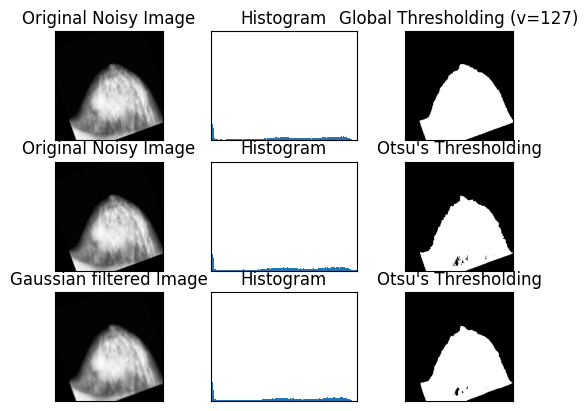

In [6]:
# global thresholding
ret1,th1 = cv2.threshold(img,60,255,cv2.THRESH_BINARY)
# Otsu's thresholding
ret2,th2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# Otsu's thresholding after Gaussian filtering
blur = cv2.GaussianBlur(img,(5,5),0)
ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# plot all the images and their histograms
images = [img, 0, th1,
 img, 0, th2,
 blur, 0, th3]
titles = ['Original Noisy Image','Histogram','Global Thresholding (v=127)',
 'Original Noisy Image','Histogram',"Otsu's Thresholding",
 'Gaussian filtered Image','Histogram',"Otsu's Thresholding"]
for i in range(3):
    plt.subplot(3, 3, i*3+1), plt.imshow(images[i*3], 'gray')
    plt.title(titles[i*3]), plt.xticks([]), plt.yticks([])
    plt.subplot(3, 3, i*3+2), plt.hist(images[i*3].ravel(), bins=256, range=[0, 256])
    plt.title(titles[i*3+1]), plt.xlim([0, 256]), plt.ylim([0, 5000]), plt.xticks([]), plt.yticks([])
    plt.subplot(3, 3, i*3+3), plt.imshow(images[i*3+2], 'gray')
    plt.title(titles[i*3+2]), plt.xticks([]), plt.yticks([])
plt.show

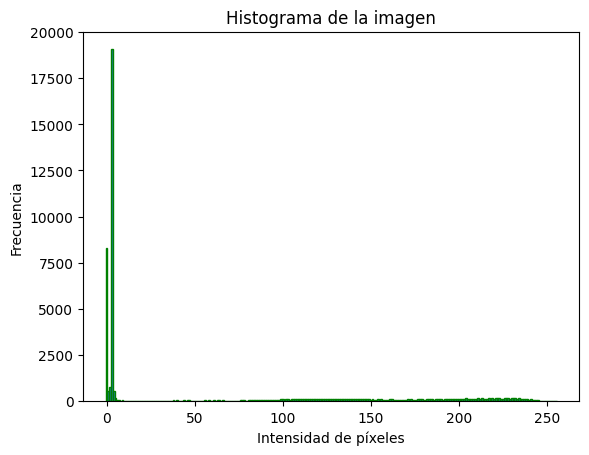

In [7]:
def mostrar_histograma(img):

    hist = cv2.calcHist([img], [0], None, [256], [0, 256])


    plt.bar(np.arange(256), hist[:, 0], width=1.0, edgecolor='green')
    plt.title('Histograma de la imagen')
    plt.xlabel('Intensidad de píxeles')
    plt.ylabel('Frecuencia')
    plt.show()


mostrar_histograma(img)

In [8]:
# Mostrar las imágenes
def img_compar2(img1, img3, img4):
    plt.figure(figsize=(12, 12))
    plt.subplot(2, 2, 1)
    plt.imshow(img1, cmap='gray')
    plt.title('Imagen Original')

    plt.subplot(2, 2, 2)
    plt.imshow(img3, cmap='gray')
    plt.title('Imagen Segmentada con K-means')

    plt.subplot(2, 2, 3)
    plt.imshow(img4, cmap='gray')
    plt.title('Imagen Preprocesada')

    plt.show()



In [9]:
# Leer las imagenes originales con sus etiquetas

imgs, labels = read_imageResize_with_labels(dir='../database/datasetV3')

In [10]:
# Comprobar la cantidad
print(imgs.shape)
print(len(labels))

(3851, 224, 224)
3851


In [11]:
imgs[0]

array([[3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       ...,
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3]], dtype=uint8)

In [12]:
# Verificar normalizacion
unicos = np.unique(imgs[0])
max(unicos)

251

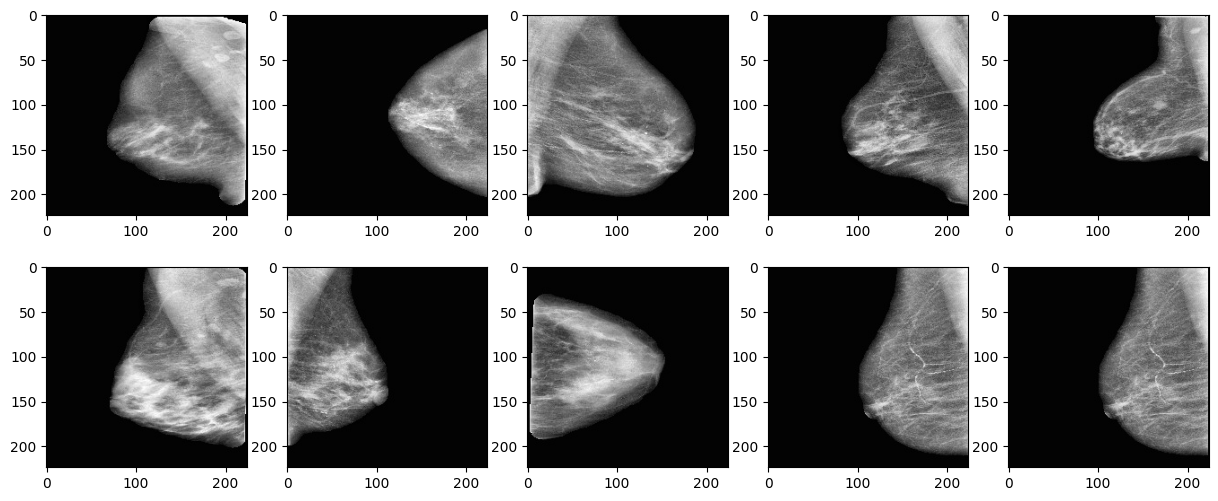

In [13]:
def show_imgs(imgs):
    '''
    Muestra una lista de imágenes en una matriz de 2 filas y 5 columnas utilizando Matplotlib.

    Parametros:
    - imgs: Una lista de matrices numpy representando las imágenes a mostrar.
    
    Esta función crea una figura con subtramas dispuestas en una matriz de 2x5.
    Recorre la lista de imágenes y las muestra en estas subtramas. Si hay menos de
    10 imágenes en la lista, los espacios restantes en la matriz quedan en blanco.
    '''
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))

    for i in range(2):
        for j in range(5):
            if i*5 + j < len(imgs):
                axes[i, j].imshow(imgs[i*5 + j],cmap = 'gray')
                #axes[i, j].axis('off')

    plt.show()
    
show_imgs(imgs)

Dado la comparación de las imágenes con filtro gaussiano y las originales del dataset, se decide no aplicar este filtro ya que el suavisado produce que las imágenes de vean borrosas, a diferencias de lo hecho con CLAHE que aumente el contraste de la imagen

In [14]:
unique_labels, unique_counts = np.unique(labels, return_counts=True)

# Crea un diccionario con las etiquetas y sus conteos
labels_histogram = dict(zip(unique_labels, unique_counts))

print(labels_histogram)

{0: 1967, 1: 1884}


In [15]:
image_data = np.array(imgs)
labels = np.array(labels)



X_train=[]
X_test=[]
y_train=[]
y_test = []



In [16]:
del imgs

In [17]:

# Dividir en conjuntos de entrenamiento (70%) y temporal (30%), manteniendo el balance de etiquetas
X_train, X_temp, y_train, y_temp = train_test_split(image_data, labels, test_size=0.3, stratify=labels, random_state=42)

# Dividir el conjunto temporal en validación y prueba, manteniendo el balance de etiquetas
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

from collections import Counter 
# Verificar las proporciones en los conjuntos de entrenamiento, validación y prueba
print("Proporciones en el conjunto de entrenamiento:", Counter(y_train))
print("Proporciones en el conjunto de validación:", Counter(y_val))
print("Proporciones en el conjunto de prueba:", Counter(y_test))


Proporciones en el conjunto de entrenamiento: Counter({0: 1377, 1: 1318})
Proporciones en el conjunto de validación: Counter({0: 295, 1: 283})
Proporciones en el conjunto de prueba: Counter({0: 295, 1: 283})


In [18]:
del image_data

In [19]:
print(type(X_train))

<class 'numpy.ndarray'>


In [20]:
print("Forma de X_train:", X_train.shape)
print("Forma de X_val:", X_val.shape)
print("Forma de X_test:", X_test.shape)
print("Forma de y_train:", y_train.shape)
print("Forma de y_val:", y_val.shape)
print("Forma de y_test:", y_test.shape)

Forma de X_train: (2695, 224, 224)
Forma de X_val: (578, 224, 224)
Forma de X_test: (578, 224, 224)
Forma de y_train: (2695,)
Forma de y_val: (578,)
Forma de y_test: (578,)


In [21]:
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
X_val = np.expand_dims(X_val,axis=-1)


# Verifica las nuevas formas
print(f"Nueva forma de datos de entrenamiento: {X_train.shape}")
print(f"Nueva forma de datos de prueba: {X_test.shape}")
print(f"Nueva forma de datos de validacion: {X_test.shape}")

Nueva forma de datos de entrenamiento: (2695, 224, 224, 1)
Nueva forma de datos de prueba: (578, 224, 224, 1)
Nueva forma de datos de validacion: (578, 224, 224, 1)


In [22]:
X_train[4]

array([[[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       ...,

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]]], dtype=uint8)

In [23]:
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

# Convertir las etiquetas a codificación one-hot
y_train_one_hot = to_categorical(y_train, num_classes=2)
y_test_one_hot = to_categorical(y_test, num_classes=2)
y_val_one_hot = to_categorical(y_val, num_classes=2)

# Crea generadores de datos de imagen con aumento de datos
train_datagen = ImageDataGenerator(
    rescale=1./255  # Reescala las imágenes por el factor dado
)

test_datagen = ImageDataGenerator(rescale=1./255)

val_datagen = ImageDataGenerator(rescale=1./255)

# Crea generadores que suministrarán los datos al modelo durante el entrenamiento
train_generator = train_datagen.flow(
    X_train,
    y_train_one_hot,
    batch_size=32
)

test_generator = test_datagen.flow(
    X_test,
    y_test_one_hot,
    batch_size=32
)

val_generator = val_datagen.flow(
    X_val,
    y_val_one_hot,
    batch_size=32
)


In [43]:

# Verificar valores únicos en la imagen procesada
print("Valores únicos en la imagen procesada:", np.unique(X_train[0]))

Valores únicos en la imagen procesada: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 232 233 236
 237 239 241

In [25]:
print(y_val)

[1 1 1 1 0 0 1 0 1 0 1 1 0 0 1 1 1 0 0 0 1 0 1 1 0 0 0 0 1 0 0 1 0 1 1 1 0
 0 0 0 0 0 1 1 0 1 0 1 1 1 1 1 0 1 1 1 0 1 0 1 0 1 0 1 0 0 0 1 0 0 1 1 1 1
 1 1 1 1 1 0 1 0 0 1 1 0 0 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0
 0 0 1 0 1 0 1 1 1 0 1 1 1 1 1 1 0 1 0 1 0 0 0 1 1 0 0 0 1 0 0 0 1 1 0 1 1
 0 1 0 0 1 0 0 1 0 1 0 0 0 0 1 1 0 1 0 0 1 0 0 0 0 1 1 1 1 1 0 0 1 0 0 1 1
 1 1 1 1 1 0 1 1 1 0 0 0 0 1 0 1 0 1 1 0 0 1 0 0 0 1 0 0 1 1 1 0 0 1 0 1 1
 0 1 1 0 1 1 0 0 0 0 1 1 1 1 0 0 1 1 0 1 0 0 0 0 1 0 0 1 1 0 1 1 1 1 0 1 0
 1 1 1 0 1 1 1 1 0 0 0 1 0 0 1 0 1 0 1 0 0 1 1 1 1 0 0 1 0 1 0 0 0 0 0 0 0
 1 1 1 0 1 1 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 0 0 1 0 1 0 0 1 1 1 0 0 0 0 1 0
 1 1 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 1 1 1 0 0 1 0 0 0 1
 0 1 1 0 1 1 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 1 0 1 0 0 1
 1 1 0 0 1 1 0 0 0 0 1 0 0 1 0 0 1 0 1 1 0 0 0 1 0 1 1 0 0 0 0 1 0 1 0 1 1
 0 1 1 0 1 1 0 1 1 0 0 0 1 1 0 0 1 0 0 0 0 0 1 0 1 1 0 1 1 0 1 1 0 1 1 1 0
 1 1 0 1 1 1 0 0 0 1 0 1 

In [26]:
print("GPUs disponibles: ", tf.config.list_physical_devices('GPU'))

GPUs disponibles:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [27]:
#Early stopping para que se detenga el entranamiento si a las 5 épocas no mejora el accuracy

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=20,
    restore_best_weights=True
)


In [28]:

# callback para detener el entrenamiento si se alcanza el accuracy deseado
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy') > 0.84):
      print("Accuracy alcanzado")
      self.model.stop_training = True


In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import LeakyReLU,ELU
from tensorflow.keras import regularizers

model = Sequential()

# Primera capa convolucional
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1), padding='same'))
model.add(MaxPooling2D((2, 2)))

# Segunda capa convolucional
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
# Aplanar para pasar a las capas densas
model.add(Flatten())

# Capa completamente conectada con 64 neuronas y regularización más ligera
model.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dropout(0.3))  # Dropout más ligero para mantener más información

# Capa de salida para 3 clases
model.add(Dense(2, activation='softmax'))

In [49]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 224, 224, 32)      320       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 112, 112, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 56, 56, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 28, 28, 128)     

In [50]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [51]:
stop = myCallback()
with tf.device('/GPU:0'):
    history = model.fit(train_generator,
                        epochs=50,
                        validation_data=val_generator,
                        verbose=1,
                        callbacks=[early_stopping,stop])

Epoch 1/50
85/85 [==============================] - 8s 88ms/step - loss: 0.3219 - accuracy: 0.9065 - val_loss: 0.1370 - val_accuracy: 0.9844


In [52]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy}")

19/19 [==============================] - 0s 21ms/step - loss: 0.1453 - accuracy: 0.9844
Test Accuracy: 0.9844290614128113


In [34]:
model.save('../models/modelo9_Mejor.h5')

In [35]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [36]:
# Visualización de curvas de pérdida y precisión
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curves')
    
    plt.show()

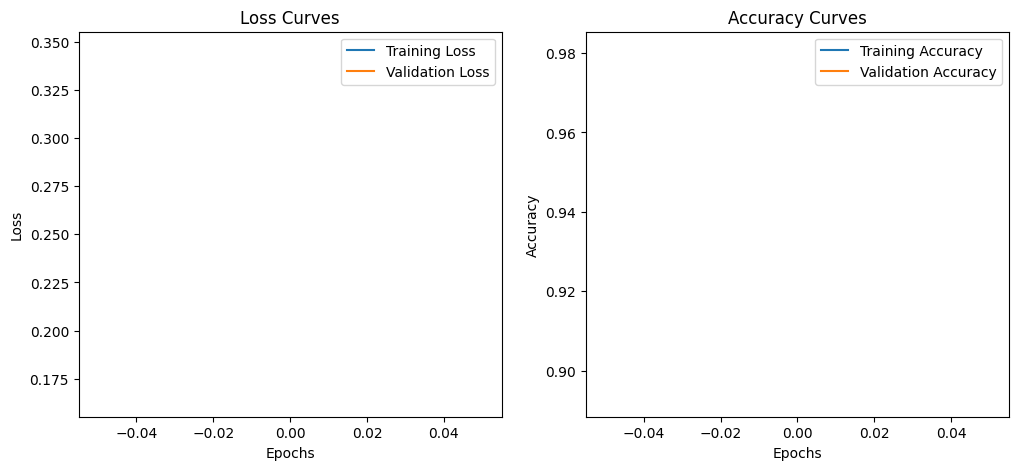

In [37]:
plot_training_history(history)

In [38]:
from sklearn.metrics import roc_curve, auc, recall_score,f1_score
import matplotlib.pyplot as plt

# Use the trained model to predict probabilities for the test set
y_pred_prob = model.predict(X_test)

# Convert y_pred_prob to a 1-dimensional array if it's 2-dimensional with only one column
if y_pred_prob.shape[1] == 1:
    y_pred_prob = y_pred_prob.ravel()

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Print the AUC score
print(f'AUC: {roc_auc:.2f}')


19/19 [==============================] - 1s 20ms/step


ValueError: y should be a 1d array, got an array of shape (578, 2) instead.

In [41]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred_prob = model.predict(X_test)

# Paso 4: Convierte las probabilidades en etiquetas de clase usando un umbral de 0.5
threshold = 0.5
y_pred_class = (y_pred_prob >= threshold).astype(int)

# Paso 5: Calcula la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_class)

# Paso 6: Muestra la matriz de confusión
print("Matriz de Confusión:")
print(conf_matrix)

# Paso 7: Visualiza la matriz de confusión usando una gráfica de calor (heatmap)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred. Normal', 'Pred. Anomalia'], yticklabels=['Real Normal', 'Real Anomalia'])
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión')
plt.show()

19/19 [==============================] - 0s 19ms/step


ValueError: Classification metrics can't handle a mix of binary and multilabel-indicator targets